# Automatic Speech Recognition using CTC

**arranger:** [hshlalla](https://hshlalla.github.io/)<br>
**Date created:** 2022/11/16<br>
**Last modified:** 2022/11/16<br>
**Description:** Training a CTC-based model for automatic speech recognition.

## Introduction
음성 인식은 컴퓨터가 구어를 텍스트로 인식하고 번역할 수 있도록 하는 방법론과 기술을 개발하는 컴퓨터 과학 및 전산 언어학의 학제간 하위 분야입니다. 자동 음성 인식(ASR), 컴퓨터 음성 인식 또는 STT(Speech to Text)라고도 합니다. 컴퓨터 과학, 언어학 및 컴퓨터 공학 분야의 지식과 연구를 통합합니다.

이 데모는 2D CNN, RNN 및 CTC(Connectionist Temporal Classification) 손실을 결합하여 ASR을 구축하는 방법을 보여줍니다. CTC는 음성 인식, 필기 인식 및 기타 시퀀스 문제에서 심층 신경망을 훈련시키는 데 사용되는 알고리즘입니다. CTC는 입력이 출력과 어떻게 정렬되는지(대본의 문자가 오디오에 어떻게 정렬되는지) 알 수 없을 때 사용됩니다. 우리가 만드는 모델은 DeepSpeech2 와 유사합니다 .

LibriVox [LibriVox](https://librivox.org/)  프로젝트 의 LJSpeech 데이터 세트를 사용합니다 . 그것은 7개의 논픽션 책에서 한 명의 화자가 읽는 구절의 짧은 오디오 클립으로 구성됩니다.


WER(단어 오류율)[Word Error Rate (WER)](https://en.wikipedia.org/wiki/Word_error_rate). 을 사용하여 모델의 품질을 평가합니다 . WER은 일련의 인식된 단어에서 발생하는 대체, 삽입 및 삭제를 합산하여 얻습니다. 그 숫자를 원래 말한 총 단어 수로 나눕니다. 결과는 WER입니다.


WER 점수를 얻으려면 jiwer 패키지를 설치해야 합니다. 다음 명령줄을 사용할 수 있습니다.

```
pip install jiwer
```

**References:**
- [Automatic Speech Recognition using CTC](https://keras.io/examples/audio/ctc_asr/)
- [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/)
- [Speech recognition](https://en.wikipedia.org/wiki/Speech_recognition)
- [Sequence Modeling With CTC](https://distill.pub/2017/ctc/)
- [DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html)
- [jiwer](https://pypi.org/project/jiwer/)

## Setup

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer


## Load the LJSpeech Dataset
데이터의 메타데이터를 받아서 말하는 speech의 문장을 학습 할 수 있도록 데이터를 받아옵니다.

Let's download the [LJSpeech Dataset](https://keithito.com/LJ-Speech-Dataset/).
The dataset contains 13,100 audio files as `wav` files in the `/wavs/` folder.
The label (transcript) for each audio file is a string
given in the `metadata.csv` file. The fields are:

- **ID**: this is the name of the corresponding .wav file
- **Transcription**: words spoken by the reader (UTF-8)
- **Normalized transcription**: transcription with numbers,
ordinals, and monetary units expanded into full words (UTF-8).

For this demo we will use on the "Normalized transcription" field.

Each audio file is a single-channel 16-bit PCM WAV with a sample rate of 22,050 Hz.

- pandas의 read_csv에 사용되는 인수
quoting / quotechar 인수의 사용
quoting 룰을 지정하고 quotechar 으로 인용구를 표현할 문자를 지정하여 인용구 설정이 적용된 csv파일의 출력이 가능하다.
quoting에 가능한 값은 {0 : MINIMAL 문자와 특수문자 / 1 : ALL 모든필드 / 2 : NONNUMERIC 숫자가 아닌것 / 3 : NONE 안함}이며, 숫자를 입력하여 지정한다.

In [51]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
# 압축파일에서 바로 언집과 path를 바로 받을 수 있다.
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True) # 모든데이터 섞어서 인덱스 리셋함.
metadata_df.head(3)


,file_name,normalized_transcription
0,LJ036-0034,"It was the intersection near Lamar Street, it was near Poydras and Lamar Street."
1,LJ035-0093,"On the basis of this time test, therefore,"
2,LJ005-0275,"religious worship, and instruction, as ""absolutely necessary for preventing contamination,"


We now split the data into training and validation set.

In [52]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 11790
Size of the training set: 1310


## Preprocessing

Stringlookup은 개별 스펠링에 인덱스를 부여한다.

In [53]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="") #oov 아웃오브 버캐블러리 사전에 없는단어나 스펠링은 이곳에서 처리
# Mapping integers back to original characters
# 숫자를 스펠링으로 돌려보냄
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [40]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


## Creating `Dataset` objects

We create a `tf.data.Dataset` object that yields
the transformed elements, in the same order as they
appeared in the input.

In [ ]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Visualize the data

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model

We first define the CTC Loss function.

In [ ]:

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [ ]:

def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

## Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


Let's start the training process.

In [ ]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)


## Inference

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)


## Conclusion

In practice, you should train for around 50 epochs or more. Each epoch
takes approximately 5-6mn using a `GeForce RTX 2080 Ti` GPU.
The model we trained at 50 epochs has a `Word Error Rate (WER) ≈ 16% to 17%`.

Some of the transcriptions around epoch 50:

**Audio file: LJ017-0009.wav**
```
- Target    : sir thomas overbury was undoubtedly poisoned by lord rochester in the reign
of james the first
- Prediction: cer thomas overbery was undoubtedly poisoned by lordrochester in the reign
of james the first
```

**Audio file: LJ003-0340.wav**
```
- Target    : the committee does not seem to have yet understood that newgate could be
only and properly replaced
- Prediction: the committee does not seem to have yet understood that newgate could be
only and proberly replace
```

**Audio file: LJ011-0136.wav**
```
- Target    : still no sentence of death was carried out for the offense and in eighteen
thirtytwo
- Prediction: still no sentence of death was carried out for the offense and in eighteen
thirtytwo
```

Example available on HuggingFace.
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/🤗%20Model-CTC%20ASR-black.svg)](https://huggingface.co/keras-io/ctc_asr) | [![Generic badge](https://img.shields.io/badge/🤗%20Spaces-CTC%20ASR-black.svg)](https://huggingface.co/spaces/keras-io/ctc_asr) |

In [11]:
from scipy import ndimage, misc
import numpy as np
import matplotlib.pyplot as plt

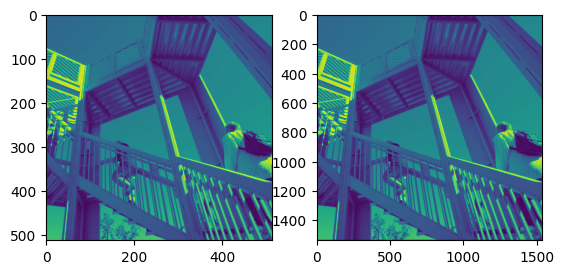

In [3]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ascent = misc.ascent()
result = ndimage.zoom(ascent, 3.0)
ax1.imshow(ascent, vmin=0, vmax=255)
ax2.imshow(result, vmin=0, vmax=255)
plt.show()

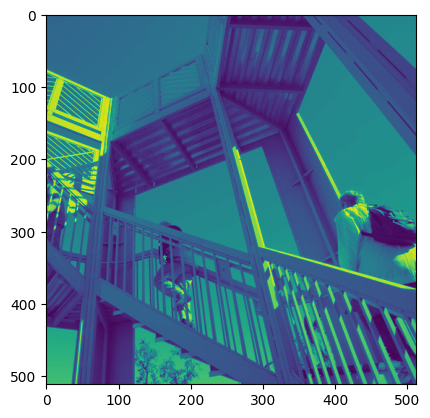

In [7]:
ndimage.zoomplt.imshow(ascent)

In [12]:
np.equal(ascent,ndimage.zoom(ascent,3.0))

ValueError: operands could not be broadcast together with shapes (512,512) (1536,1536) 

In [13]:
ndimage.zoom(ascent,3.0).shape

(1536, 1536)